In [1]:
from nir.read import read
from nir.ir import LIF

import nir

graph = read('lif_norse.nir')
for nkey, node in graph.nodes.items():
    print(f"{nkey:7} {node}")

0       Affine(weight=array([[1.]], dtype=float32), bias=array([0.], dtype=float32))
1       LIF(tau=array([0.0025], dtype=float32), r=array([1.], dtype=float32), v_leak=array([0.], dtype=float32), v_threshold=array([0.1], dtype=float32))
input   Input(input_type={'input': array([1], dtype=int64)})
output  Output(output_type={'output': array([1], dtype=int64)})


In [2]:
import nengo
import numpy as np

def nir_to_nengo(n):
    nengo_map = {}

    model = nengo.Network()
    with model:
        filters = {}
        for name, obj in n.nodes.items():
            if isinstance(obj, nir.Input):
                node = nengo.Node(None, size_in=obj.input_type['input'][0], label=f"Input {name} {obj.input_type['input']}")
                nengo_map[name] = node
            elif isinstance(obj, nir.LIF):
                assert np.all(obj.r == 1)
                assert np.all(obj.v_leak == 0)
                N = obj.tau.flatten().shape[0]
                ens = nengo.Ensemble(
                    n_neurons=N,
                    dimensions=1,
                    label=f"LIF {name}",
                    neuron_type = nengo.LIF(tau_rc=obj.tau[0], tau_ref=0, initial_state={"voltage": nengo.dists.Choice([0])}),
                    gain=np.ones(N)/obj.v_threshold,
                    bias=np.zeros(N),
                )
                nengo_map[name] = ens.neurons
            elif isinstance(obj, nir.LI):
                filt = nengo.Node(
                    None,
                    size_in=obj.tau.flatten().shape[0],
                    label=f"LI {name} {obj.tau.shape}",
                )
                filters[filt] = nengo.synapses.Lowpass(obj.tau[0])
                nengo_map[name] = filt
            elif isinstance(obj, nir.Affine):
                w = nengo.Node(
                    lambda t, x, obj=obj: obj.weight @ x + obj.bias,
                    size_in=obj.weight.shape[1],
                    size_out=obj.weight.shape[0],
                    label=f"({obj.weight.shape[0]}x{obj.weight.shape[1]})",
                )
                nengo_map[name] = w
            elif isinstance(obj, nir.Output):
                nengo_map[name] = nengo.Node(None, size_in=obj.output_type['output'][0], label=f"Output {name} {obj.input_type['input']}")
        for pre, post in n.edges:
            synapse = filters.get(nengo_map[post], None)

            if nengo_map[pre].size_out != nengo_map[post].size_in:
                print("Error")
                print("pre", nengo_map[pre])
                print("post", nengo_map[post])
                1 / 0

            else:
                nengo.Connection(nengo_map[pre], nengo_map[post], synapse=synapse)

    return model, nengo_map


In [3]:
model, nengo_map = nir_to_nengo(graph)

d0 = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
d = []
for t in d0:
    d.append(t)
    for i in range(9):
        d.append(0)

dt = 1e-4
                
with model:
    stim = nengo.Node(nengo.processes.PresentInput(d, presentation_time=dt))
    nengo.Connection(stim, nengo_map['input'], synapse=None, transform=1)
    
    p_stim = nengo.Probe(stim)
    p_output = nengo.Probe(nengo_map['output'])
    p_membrane = nengo.Probe(nengo_map['1'], 'voltage')
    
    
sim = nengo.Simulator(model, dt)
with sim:
    sim.run(len(d)*dt)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt


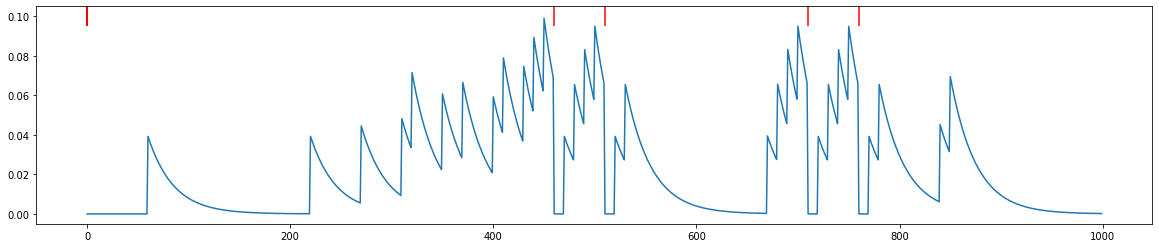

In [5]:
spikes = np.argwhere(sim.data[p_output] > 0)
plt.figure(figsize=(20, 4))
plt.plot(sim.data[p_membrane]*0.1)
plt.scatter(spikes, np.ones_like(spikes) * 0.1, marker="|", c="red", s=400)
plt.savefig("lif_trace_nengo.png")

In [6]:
import pandas
pandas.DataFrame(np.concatenate([sim.data[p_stim], 
                                 sim.data[p_membrane], 
                                 sim.data[p_output]*dt], axis=1)).to_csv("lif_nengo.csv", index=False, header=False)